In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates

In [5]:
sns.set()
%matplotlib inline

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

In [8]:
sns.set_context("talk")
sns.set_style("ticks")

## Load Data

In [11]:
# Data urls
base_url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/'

confirmed_cases_data_url = base_url + 'covid19za_provincial_cumulative_timeline_confirmed.csv'
death_cases_data_url = base_url + 'covid19za_provincial_cumulative_timeline_deaths.csv'
recovery_cases_data_url = base_url+ 'covid19za_provincial_cumulative_timeline_recoveries.csv'
vaccination_data_url = base_url+'covid19za_provincial_cumulative_timeline_vaccination.csv'
test_data_url = base_url+'covid19za_timeline_testing.csv'
hospitalization_data_url = base_url+'nicd_hospital_surveillance_data.csv'

In [12]:
raw_data_confirmed = pd.read_csv(confirmed_cases_data_url)
raw_data_deaths = pd.read_csv(death_cases_data_url)
raw_data_recovered = pd.read_csv(recovery_cases_data_url)
raw_data_vaccinated = pd.read_csv(vaccination_data_url)
raw_data_tests = pd.read_csv(test_data_url)
raw_data_hospitalized = pd.read_csv(hospitalization_data_url)

In [13]:
raw_data_confirmed.head()

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
0,05-03-2020,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
1,07-03-2020,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,NaN
2,08-03-2020,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN
3,09-03-2020,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
4,11-03-2020,20200311,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,13,NaN


In [14]:
cases_df = raw_data_confirmed[['date', 'total']]
deaths_df = raw_data_deaths[['date', 'total']]
recovery_df = raw_data_recovered[['date', 'total']]
vaccinated_df = raw_data_vaccinated[['date', 'total']]

In [16]:
# We are going to merge the cases_df, deaths_df and recovered_df
merged_df = pd.merge(cases_df, deaths_df, how='outer', on='date')
merged_df = pd.merge(merged_df,recovery_df, how='outer', on='date')

# Rename the columns
merged_df.rename(columns={'total_x': 'Confirmed', 'total_y':'Deaths', 'total':'Recovered'}, inplace=True)

In [ ]:
merged_df = merged_df.fillna(0)

In [ ]:
merged_df['Active'] = merged_df['Confirmed'] - (merged_df['Deaths'] + merged_df['Recovered'])

In [ ]:
#merged_df = merged_df['Confirmed'] - merged_df['Confirmed'].shift(1)
merged_df['Daily Confirmed'] = merged_df['Confirmed']- merged_df['Confirmed'].shift(1)
merged_df['Daily Fatalities'] = merged_df['Deaths']- merged_df['Deaths'].shift(1)
merged_df['Daily Recovered'] = merged_df['Recovered']- merged_df['Recovered'].shift(1)

In [25]:
merged_df.head()

,date,Confirmed,Deaths,Recovered,Active
0,05-03-2020,1,0.0,0.0,1.0
1,07-03-2020,2,0.0,0.0,2.0
2,08-03-2020,3,0.0,0.0,3.0
3,09-03-2020,7,0.0,0.0,7.0
4,11-03-2020,13,0.0,0.0,13.0


In [28]:
merged_df.tail()
#Fix the large deviations by moving the previous value to current if current is zero

,date,Confirmed,Deaths,Recovered,Active,Daily Confirmed,Daily Fatalities,Daily Recovered
792,08-05-2022,3841389,100523.0,3679053.0,61813.0,5486.0,7.0,2243.0
793,09-05-2022,3844626,100533.0,3680855.0,63238.0,3237.0,10.0,1802.0
794,10-05-2022,3852149,0.0,0.0,3852149.0,7523.0,-100533.0,-3680855.0
795,11-05-2022,3862166,100609.0,3691684.0,69873.0,10017.0,100609.0,3691684.0
796,12-05-2022,3871086,0.0,0.0,3871086.0,8920.0,-100609.0,-3691684.0


pandas.core.series.Series

In [39]:
merged_df.columns = ['date', 'Confirmed', 'Deaths', 'Recovered', 'Active','Daily Confirmed', 'Daily Fatalities', 'Daily Recovered']
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%d-%m-%Y')
merged_df = merged_df.sort_values(by='date')
merged_df.head()

,date,Confirmed,Deaths,Recovered,Active,Daily Confirmed,Daily Fatalities,Daily Recovered
0,2020-03-05,1,0.0,0.0,1.0,NaN,NaN,NaN
1,2020-03-07,2,0.0,0.0,2.0,1.0,0.0,0.0
2,2020-03-08,3,0.0,0.0,3.0,1.0,0.0,0.0
3,2020-03-09,7,0.0,0.0,7.0,4.0,0.0,0.0
4,2020-03-11,13,0.0,0.0,13.0,6.0,0.0,0.0


## Data is usually entered with some lag, so let’s add moving-average smoothed versions of all columns to use them later.

In [41]:
df_smoothed = merged_df.rolling(7).mean().round(5)
df_smoothed.columns = [col + '_ma7' for col in df_smoothed.columns]

full_df = pd.concat([merged_df, df_smoothed], axis=1)
for column in full_df.columns:
    if column.endswith('_ma7'):
        original_column = column.strip('_ma7')
        full_df[column] = full_df[column].fillna(full_df[original_column])

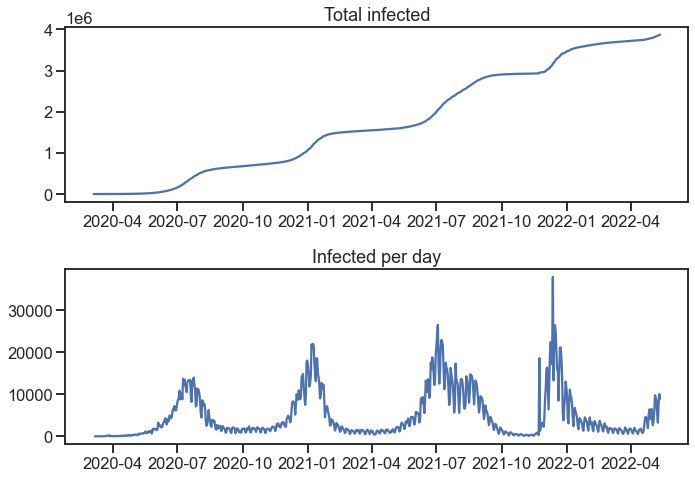

In [44]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot(2, 1, 1)
# df.total_infected.plot()
plt.plot(merged_df.date, merged_df['Confirmed'].values)
plt.title("Total infected")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(merged_df.date, merged_df['Daily Confirmed'].values)
plt.title("Infected per day")
plt.tight_layout()
plt.show()

In [45]:
df = full_df

In [47]:
from IPython.display import display, HTML

display(df)
# display(HTML(df.to_html()))

,date,Confirmed,Deaths,Recovered,Active,Daily Confirmed,Daily Fatalities,Daily Recovered,Confirmed_ma7,Deaths_ma7,Recovered_ma7,Active_ma7,Daily Confirmed_ma7,Daily Fatalities_ma7,Daily Recovered_ma7
0,2020-03-05,1,0.0,0.0,1.0,NaN,NaN,NaN,1.000000e+00,0.00000,0.000000e+00,1.000000e+00,NaN,NaN,NaN
1,2020-03-07,2,0.0,0.0,2.0,1.0,0.0,0.0,2.000000e+00,0.00000,0.000000e+00,2.000000e+00,1.00000,0.00000,0.00000
2,2020-03-08,3,0.0,0.0,3.0,1.0,0.0,0.0,3.000000e+00,0.00000,0.000000e+00,3.000000e+00,1.00000,0.00000,0.00000
3,2020-03-09,7,0.0,0.0,7.0,4.0,0.0,0.0,7.000000e+00,0.00000,0.000000e+00,7.000000e+00,4.00000,0.00000,0.00000
4,2020-03-11,13,0.0,0.0,13.0,6.0,0.0,0.0,1.300000e+01,0.00000,0.000000e+00,1.300000e+01,6.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,2022-05-08,3841389,100523.0,3679053.0,61813.0,5486.0,7.0,2243.0,3.818826e+06,100452.71429,3.667795e+06,5.057743e+04,6517.85714,22.85714,4134.00000
793,2022-05-09,3844626,100533.0,3680855.0,63238.0,3237.0,10.0,1802.0,3.825427e+06,100476.00000,3.671965e+06,5.298586e+04,6601.71429,23.28571,4170.00000
794,2022-05-10,3852149,0.0,0.0,3852149.0,7523.0,-100533.0,-3680855.0,3.832563e+06,86136.42857,3.148875e+06,5.975519e+05,7135.71429,-14339.57143,-523090.71429
795,2022-05-11,3862166,100609.0,3691684.0,69873.0,10017.0,100609.0,3691684.0,3.840248e+06,86165.28571,3.152951e+06,6.011324e+05,7685.28571,28.85714,4075.85714


In [49]:
NEW_STRAIN_DATE = '2021-08-10'

In [50]:
train_subset = df[(df.date <= NEW_STRAIN_DATE)]

## Classic SEIRD Model

In [51]:
import lmfit

In [86]:
class SEIR_MODEL:
    #def __init__(self, params=None):
        #self.params = params
    def __init__(self, stepwise_size=60, params=None):
        super().__init__()
        self.stepwise_size = stepwise_size
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=60_697_206, vary=False) # South Africa Population
        params.add("epidemic_started_days_ago", value=10, vary=False) #Change values to depict true start date
        params.add("r0", value=4, min=3, max=5, vary=True)
        params.add("alpha", value=0.0064, min=0.005, max=0.0078, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D) = self.predict(t, (population - 1, 0, 1, 0, 0))

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T

In [87]:
model = SEIR_MODEL()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D) = model.predict(train_t, train_initial_conditions)

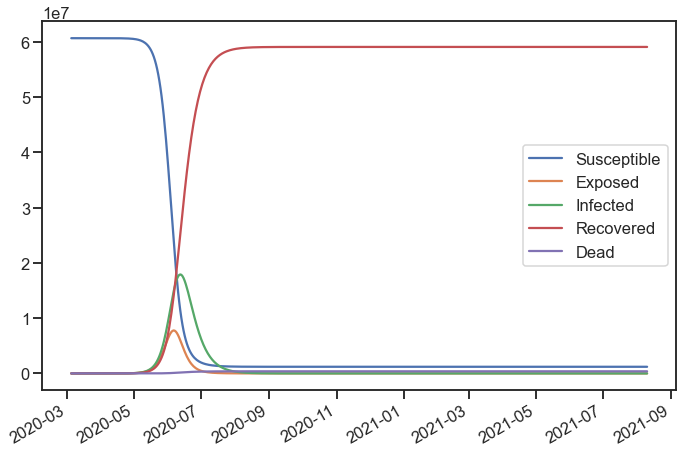

In [88]:
fig = plt.figure(figsize=(10,7))
plt.plot(train_subset.date, S, label='Susceptible')
plt.plot(train_subset.date, E, label='Exposed')
plt.plot(train_subset.date, I, label='Infected')
plt.plot(train_subset.date, R, label='Recovered')
plt.plot(train_subset.date, D, label='Dead')
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

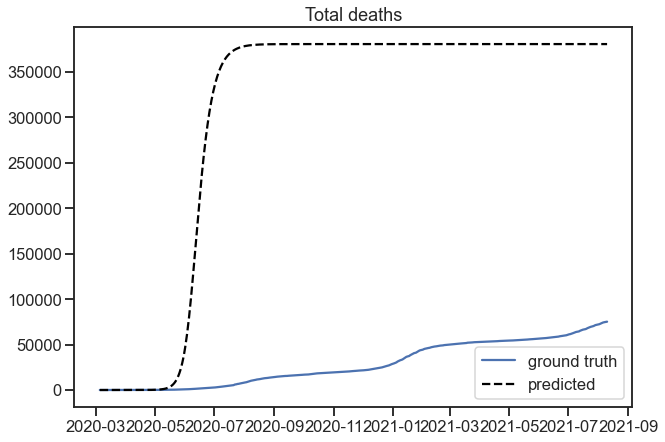

In [89]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['Deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted', color='black', linestyle='dashed' )
plt.legend()
plt.title('Total deaths')
plt.show()

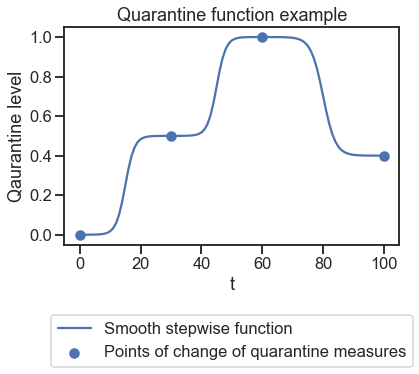

In [90]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(100)
coefficients = {
    0: 0,
    30: 0.5,
    60: 1,
    100: 0.4,
}

plt.title('Quarantine function example')
plt.scatter(coefficients.keys(), coefficients.values(), label='Points of change of quarantine measures')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Smooth stepwise function')
plt.xlabel('t')
plt.ylabel('Qaurantine level')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

In [77]:
import numpy as np
from tqdm.auto import tqdm
from joblib import Parallel, delayed


def smape(true, pred, eps=1e-5):
    return np.abs((true - pred) / (np.abs(true) + np.abs(pred) + eps)).mean()


def rel_error(true, pred, eps=1e-5):
    return (true - pred) / (np.maximum(true, pred) + eps)


def shift(arr, num, fill_value=np.nan):
    if num >= 0:
        return np.concatenate((np.full(num, fill_value), arr[:-num]))
    else:
        return np.concatenate((arr[-num:], np.full(-num, fill_value)))


def pad_left(arr, n_zeros=1):
    return np.pad(arr, (n_zeros, 0))


def stepwise(t, coefficients):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        index = min_index
    elif t >= max_index:
        index = max_index
    else:
        index = np.min(t_arr[t_arr >= t])
    return coefficients[index]


def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out


def eval_on_select_dates_and_k_days_ahead(df,
                                     eval_func,
                                     eval_dates,
                                     k=7,
                                     verbose=True,
                                     n_jobs=-1):


    def process_date(date):
        t = len(df[df.date < date])
        train_df = df.iloc[:t]

        train_t = np.arange(len(train_df))
        eval_t = np.arange(train_t[-1] + 1, t + k, 1)

        model, fitter, test_states = eval_func(train_df, t, train_t, eval_t)

        test_df = df.iloc[eval_t]

        return (train_df, test_df, test_states, fitter, model)

    results = Parallel(n_jobs=n_jobs, verbose=11 if verbose else 0)(delayed(process_date)(date) for date in eval_dates)

    train_dfs = [x[0] for x in results]
    test_dfs = [x[1] for x in results]
    model_predictions = [x[2] for x in results]
    fitters = [x[3] for x in results]
    models = [x[4] for x in results]

    return models, fitters, model_predictions, train_dfs, test_dfs

In [79]:
import numpy as np
import lmfit
from lmfit import Parameters, minimize
from copy import deepcopy
from tqdm.auto import tqdm


def smape_resid_transform(true, pred, eps=1e-5):
    return (true - pred) / (np.abs(true) + np.abs(pred) + eps)


class BaseFitter:
    def __init__(self,
                 result=None,
                 verbose=True,
                 max_iters=None,
                 brute_params=None,
                 save_params_every=100,
                 resid_transform=smape_resid_transform):
        self.result = result
        self.verbose = verbose
        self.max_iters = max_iters
        self.brute_params = brute_params or []
        self.resid_transform = resid_transform
        self.save_params_every = save_params_every
        self.params_history = []
        self.error_history = []

        self._last_resid = None
        self._last_params = None
        self._terminated = False

    def residual(self, params, t_vals, data, model):
        pass

    def optimize(self, params, t, data, model, *args, **kwargs):
        with tqdm(total=self.max_iters) as pbar:
            def callback(params, iter, resid, *args, **kwargs):
                if iter != self.max_iters:
                    self._last_resid = resid
                    self._last_params = params
                    if (iter % 10 == 0):
                        pbar.n = iter
                        pbar.refresh()
                        pbar.set_postfix({"Error": np.abs(resid).mean()})

                    if (iter % self.save_params_every == 0 and iter > 0):
                        error = np.abs(resid).mean()
                        self.params_history.append(deepcopy(params))
                        self.error_history.append(error)
                else:
                    print('Reached max iters')

            minimize_result = minimize(self.residual,
                                      params,
                                      *args,
                                      args=(t, data, model),
                                      iter_cb=callback,
                                      max_nfev=self.max_iters,
                                      **kwargs)

        if not minimize_result.success:
            minimize_result.params = self._last_params
            minimize_result.residual = self._last_resid

        self._last_resid = None
        self._last_params = None
        return minimize_result

    def optimize_brute(self, params, param_name, brute_params, t, data, model, *args, **kwargs):
        best_result = None
        param = params[param_name]
        assert not param.vary
        param_min, param_max, param_step = param.min, param.max, param.brute_step

        last_params = deepcopy(params)
        iterator = tqdm(range(param_min, param_max + 1, param_step))
        for param_val in iterator:
            iterator.set_postfix({param_name: param_val})

            temp_params = last_params
            temp_params[param_name].value = param_val
            if brute_params:
                result = self.optimize_brute(temp_params, brute_params[0], brute_params[1:], t, data, model, *args, **kwargs)
            else:
                result = self.optimize(temp_params, t, data, model, *args, **kwargs)

            if not best_result or np.mean(np.abs(result.residual)) < np.mean(np.abs(best_result.residual)):
                best_result = result

            # Start optimization from last best point
            last_params = deepcopy(result.params)

        return best_result

    def fit(self, model, data, *args, **kwargs):
        params = model.get_fit_params(data)
        t = np.arange(len(data))

        if not self.brute_params:
            self.result = self.optimize(params, t, data, model, *args, **kwargs)
        else:
            self.result = self.optimize_brute(params, self.brute_params[0], self.brute_params[1:], t, data, model, *args, **kwargs)

        model.params = self.result.params


class CurveFitter(BaseFitter):
    def __init__(self, *args,
                 new_deaths_col='deaths_per_day',
                 new_cases_col='infected_per_day',
                 new_recoveries_col='recovered_per_day',
                 weights=None,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.new_deaths_col = new_deaths_col
        self.new_cases_col = new_cases_col
        self.new_recoveries_col = new_recoveries_col
        self.weights = weights

    def residual(self, params, t_vals, data, model):
        model.params = params

        initial_conditions = model.get_initial_conditions(data)

        (S, E, I, R, D), history = model.predict(t_vals, initial_conditions, history=True)
        new_exposed, new_infected, new_recovered, new_dead = model.compute_daily_values(S, E, I, R, D)
        true_daily_cases = data[self.new_cases_col].values[1:]
        true_daily_deaths = data[self.new_deaths_col].values[1:]
        true_daily_recoveries = data[self.new_recoveries_col].values[1:]

        resid_I_new = self.resid_transform(true_daily_cases, new_infected)
        resid_D_new = self.resid_transform(true_daily_deaths, new_dead)
        resid_R_new = self.resid_transform(true_daily_recoveries, new_recovered)

        if self.weights:
            residuals = np.concatenate([
                self.weights['I'] * resid_I_new,
                self.weights['D'] * resid_D_new,
                self.weights['R'] * resid_R_new,
            ]).flatten()
        else:
            residuals = np.concatenate([
                resid_I_new,
                resid_D_new,
                resid_R_new,
            ]).flatten()
        return residuals


class HiddenCurveFitter(CurveFitter):
    def __init__(self, *args,
                 new_recoveries_col='recovered_per_day',
                 weights=None,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.new_recoveries_col = new_recoveries_col
        self.weights = weights

    def residual(self, params, t_vals, data, model):
        model.params = params

        initial_conditions = model.get_initial_conditions(data)

        (S, E, I, Iv, R, Rv, D, Dv), history = model.predict(t_vals, initial_conditions, history=False)
        (new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

        new_infected_visible = new_infected_visible
        new_dead_visible = new_dead_visible
        new_recovered_visible = new_recovered_visible

        true_daily_cases = data[self.new_cases_col].values[1:]
        true_daily_deaths = data[self.new_deaths_col].values[1:]
        true_daily_recoveries = data[self.new_recoveries_col].values[1:]

        resid_I_new = self.resid_transform(true_daily_cases, new_infected_visible)
        resid_D_new = self.resid_transform(true_daily_deaths, new_dead_visible)
        resid_R_new = self.resid_transform(true_daily_recoveries, new_recovered_visible)

        if self.weights:
            residuals = np.concatenate([
                self.weights['I'] * resid_I_new,
                self.weights['D'] * resid_D_new,
                self.weights['R'] * resid_R_new,
            ]).flatten()
        else:
            residuals = np.concatenate([
                resid_I_new,
                resid_D_new,
                resid_R_new,
            ]).flatten()

        return residuals

In [71]:

def smape_resid_transform(true, pred, eps=1e-5):
    return (true - pred) / (np.abs(true) + np.abs(pred) + eps)

class HiddenCurveFitter(BaseFitter):
    def residual(self, params, t_vals, data, model):
        model.params = params

        initial_conditions = model.get_initial_conditions(data)

        (S, E, I, Iv, R, Rv, D, Dv), history = model.predict(t_vals, initial_conditions, history=False)
        (new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

        new_infected_visible = new_infected_visible
        new_dead_visible = new_dead_visible
        new_recovered_visible = new_recovered_visible

        true_daily_cases = data[self.new_cases_col].values[1:]
        true_daily_deaths = data[self.new_deaths_col].values[1:]
        true_daily_recoveries = data[self.new_recoveries_col].values[1:]

        resid_I_new = smape_resid_transform(true_daily_cases, new_infected_visible)
        resid_D_new = smape_resid_transform(true_daily_deaths, new_dead_visible)
        resid_R_new = smape_resid_transform(true_daily_recoveries, new_recovered_visible)

        if self.weights:
            residuals = np.concatenate([
                self.weights['I'] * resid_I_new,
                self.weights['D'] * resid_D_new,
                self.weights['R'] * resid_R_new,
            ]).flatten()
        else:
            residuals = np.concatenate([
                resid_I_new,
                resid_D_new,
                resid_R_new,
            ]).flatten()

        return residuals

In [100]:
class SEIR:
    def __init__(self, stepwise_size=60, params=None):
        super().__init__()
        self.stepwise_size = stepwise_size
        self.params = params

    def get_fit_params(self, data):
        params = Parameters()
        params.add("population", value=12_000_000, vary=False)

        params.add("sigmoid_r", value=20, min=1, max=30, brute_step=1, vary=False)
        params.add("sigmoid_c", value=0.5, min=0, max=1, brute_step=0.1, vary=False)

        params.add("epidemic_started_days_ago", value=10, min=1, max=90, brute_step=10, vary=False)

        params.add("r0", value=4, min=3, max=5, brute_step=0.05, vary=True)

        params.add("alpha", value=0.0064, min=0.005, max=0.0078, brute_step=0.0005, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=False)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate

        params.add("incubation_days", expr='1/delta', vary=False)
        params.add("infectious_days", expr='1/gamma', vary=False)

        params.add(f"t0_q", value=0, min=0, max=0.99, brute_step=0.1, vary=False)
        piece_size = self.stepwise_size
        for t in range(piece_size, len(data), piece_size):
            params.add(f"t{t}_q", value=0.5, min=0, max=0.99, brute_step=0.1, vary=True)
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        new_params = deepcopy(self.params)
        for key, value in new_params.items():
            if key.startswith('t'):
                new_params[key].value = 0
        new_model = self.__class__(params=new_params)

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D), history = new_model.predict(t, (population - 1, 0, 1, 0, 0), history=False)

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def compute_daily_values(self, S, E, I, R, D):
        new_dead = (np.diff(D))
        new_recovered = (np.diff(R))
        new_infected = (np.diff(I)) + new_recovered + new_dead
        new_exposed = (np.diff(S[::-1])[::-1])

        return new_exposed, new_infected, new_recovered, new_dead

    def get_step_rt_beta(self, t, params):
        r0 = params['r0']
        gamma = params['gamma']
        sigmoid_r = params['sigmoid_r']
        sigmoid_c = params['sigmoid_c']

        q_coefs = {}
        for key, value in params.items():
            if key.startswith('t'):
                coef_t = int(key.split('_')[0][1:])
                q_coefs[coef_t] = value.value

        quarantine_mult = stepwise_soft(t, q_coefs, r=sigmoid_r, c=sigmoid_c)
        rt = r0 - quarantine_mult * r0
        beta = rt * gamma
        return quarantine_mult, rt, beta

    def step(self, initial_conditions, t, params, history_store):
        population = params['population']
        delta = params['delta']
        gamma = params['gamma']
        alpha = params['alpha']
        rho = params['rho']

        quarantine_mult, rt, beta = self.get_step_rt_beta(t, params)

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10

        if history_store is not None:
            history_record = {
                't': t+1,
                'quarantine_mult': quarantine_mult,
                'rt': rt,
                'beta': beta,
                'new_exposed': new_exposed,
                'new_infected': new_infected,
                'new_dead': new_dead,
                'new_recovered': new_recovered,
            }
            history_store.append(history_record)

        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t, initial_conditions, history=True):
        if history == True:
            history = []
        else:
            history = None

        ret = odeint(self.step, initial_conditions, t, args=(self.params, history))

        if history:
            history = pd.DataFrame(history)
            if not history.empty:
                history.index = history.t
                history = history[~history.index.duplicated(keep='first')]
        return ret.T, history


class SEIRHidden(SEIR):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)

        params.add("pi", value=0.2, min=0.15, max=0.3, brute_step=0.01, vary=True)  # Probability to discover a new infected case in a day
        params.add("pd", value=0.35, min=0.15, max=0.9, brute_step=0.05, vary=True)  # Probability to discover a death
        return params

    def get_initial_conditions(self, data):
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        new_params = deepcopy(self.params)
        for key, value in new_params.items():
            if key.startswith('t'):
                new_params[key].value = 0
        new_model = self.__class__(params=new_params)

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, Iv, R, Rv, D, Dv), history = new_model.predict(t, (population-1, 0, 1, 0, 0, 0, 0, 0), history=False)

        S0 = S[-1]
        E0 = E[-1]
        I0 = I[-1]
        Iv0 = Iv[-1]
        R0 = R[-1]
        Rv0 = Rv[-1]
        D0 = D[-1]
        Dv0 = Dv[-1]
        return (S0, E0, I0, Iv0, R0, Rv0, D0, Dv0)

    def step(self, initial_conditions, t, params, history_store):
        population = params['population']
        delta = params['delta']
        gamma = params['gamma']
        alpha = params['alpha']
        rho = params['rho']
        pi = params['pi']
        pd = params['pd']

        quarantine_mult, rt, beta = self.get_step_rt_beta(t, params)

        (S, E, I, Iv, R, Rv, D, Dv) = initial_conditions

        new_exposed = beta * (I+Iv) * (S / population)
        new_infected_inv = (1 - pi) * delta * E
        new_recovered_inv = gamma * (1 - alpha) * I
        new_dead_inv = (1 - pd) * alpha * rho * I
        new_dead_vis_from_I = pd * alpha * rho * I

        new_infected_vis = pi * delta * E
        new_recovered_vis = gamma * (1 - alpha) * Iv
        new_dead_vis_from_Iv = alpha * rho * Iv

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected_vis - new_infected_inv
        dIdt = new_infected_inv - new_recovered_inv - new_dead_inv - new_dead_vis_from_I
        dIvdt = new_infected_vis - new_recovered_vis - new_dead_vis_from_Iv
        dRdt = new_recovered_inv
        dRvdt = new_recovered_vis
        dDdt = new_dead_inv
        dDvdt = new_dead_vis_from_I + new_dead_vis_from_Iv

        assert S + E + I + Iv + R + Rv + D + Dv - population <= 1e10
        assert dSdt + dEdt + dIdt + dIvdt + dRdt + dRvdt + dDdt + dDvdt <= 1e10

        if history_store is not None:
            history_record = {
                't': t+1,
                'quarantine_mult': quarantine_mult,
                'rt': rt,
                'beta': beta,
                'new_exposed': new_exposed,
                'new_infected_vis': new_infected_vis,
                'new_dead_vis': new_dead_vis_from_I + new_dead_vis_from_Iv,
                'new_recovered_vis': new_recovered_vis,
                'new_infected_inv': new_infected_inv,
                'new_dead_inv': new_dead_inv,
                'new_recovered_inv': new_recovered_inv,
            }
            history_store.append(history_record)

        return dSdt, dEdt, dIdt, dIvdt, dRdt, dRvdt, dDdt, dDvdt

    def compute_daily_values(self, S, E, I, Iv, R, Rv, D, Dv):
        new_dead_inv = (np.diff(D))
        new_recovered_inv = (np.diff(R))
        new_recovered_vis = (np.diff(Rv))
        new_exposed = (np.diff(S[::-1])[::-1])

        new_dead_vis_from_Iv = self.params['alpha'] * self.params['rho'] * (shift(Iv, 1)[1:])
        new_dead_vis_from_I = (np.diff(Dv)) - new_dead_vis_from_Iv
        new_dead_vis = new_dead_vis_from_Iv + new_dead_vis_from_I

        new_infected_vis = (np.diff(Iv)) + new_recovered_vis + new_dead_vis_from_Iv
        new_infected_inv = (np.diff(I)) + new_recovered_inv + new_dead_vis_from_I

        return new_exposed, new_infected_inv, new_infected_vis, new_recovered_inv, new_recovered_vis, new_dead_inv, new_dead_vis


class SEIRHiddenTwoStrains(SEIRHidden):

    @classmethod
    def from_strain_one_model(cls, model):
        strain1_params = model.params
        strain1_params.add("beta2_mult", value=1.5, min=1, max=2, vary=False)
        return cls(params=deepcopy(strain1_params))

    def get_fit_params(self, data):
        raise Exception('2 strain models can\'t be fit. Fit a one strain model, then use `from_strain_one_model`')

    def step(self, initial_conditions, t, params, history_store):
        population = params['population']
        delta = params['delta']
        gamma = params['gamma']
        alpha = params['alpha']
        rho = params['rho']
        pi = params['pi']
        pd = params['pd']
        beta2_mult = params['beta2_mult']

        quarantine_mult, rt1, beta1 = self.get_step_rt_beta(t, params)

        beta2 = beta2_mult * beta1
        (S, E1, I1, Iv1, E2, I2, Iv2, R, Rv, D, Dv) = initial_conditions

        new_exposed_s1 = beta1 * (I1 + Iv1) * (S / population)
        new_infected_inv_s1 = (1 - pi) * delta * E1
        new_infected_vis_s1 = pi * delta * E1
        new_recovered_inv_s1 = gamma * (1 - alpha) * I1
        new_recovered_vis_s1 = gamma * (1 - alpha) * Iv1
        new_dead_inv_s1 = (1 - pd) * alpha * rho * I1
        new_dead_vis_from_I_s1 = pd * alpha * rho * I1
        new_dead_vis_from_Iv_s1 = alpha * rho * Iv1

        new_exposed_s2 = beta2 * (I2 + Iv2) * (S / population)
        new_infected_inv_s2 = (1 - pi) * delta * E2
        new_infected_vis_s2 = pi * delta * E2
        new_recovered_inv_s2 = gamma * (1 - alpha) * I2
        new_recovered_vis_s2 = gamma * (1 - alpha) * Iv2
        new_dead_inv_s2 = (1 - pd) * alpha * rho * I2
        new_dead_vis_from_I_s2 = pd * alpha * rho * I2
        new_dead_vis_from_Iv_s2 = alpha * rho * Iv2

        dSdt = -(new_exposed_s1 + new_exposed_s2)

        dE1dt = new_exposed_s1 - new_infected_vis_s1 - new_infected_inv_s1
        dI1dt = new_infected_inv_s1 - new_recovered_inv_s1 - new_dead_inv_s1 - new_dead_vis_from_I_s1
        dIv1dt = new_infected_vis_s1 - new_recovered_vis_s1 - new_dead_vis_from_Iv_s1

        dE2dt = new_exposed_s2 - new_infected_vis_s2 - new_infected_inv_s2
        dI2dt = new_infected_inv_s2 - new_recovered_inv_s2 - new_dead_inv_s2 - new_dead_vis_from_I_s2
        dIv2dt = new_infected_vis_s2 - new_recovered_vis_s2 - new_dead_vis_from_Iv_s2

        dRdt = new_recovered_inv_s1 + new_recovered_inv_s2
        dRvdt = new_recovered_vis_s1 + new_recovered_vis_s2
        dDdt = new_dead_inv_s1 + new_dead_inv_s2
        dDvdt = new_dead_vis_from_I_s1 + new_dead_vis_from_Iv_s1 + new_dead_vis_from_I_s2 + new_dead_vis_from_Iv_s2

        assert S + E1 + I1 + Iv1 + E2 + I2 + Iv2 + R + Rv + D + Dv - population <= 1e10
        assert dSdt + dE1dt + dI1dt + dIv1dt + dE2dt + dI2dt + dIv2dt + dRdt + dRvdt + dDdt + dDvdt <= 1e10

        history_record = {
            't': t+1,
            'quarantine_mult': quarantine_mult,
            'rt_strain1': rt1,
            'rt_strain2': beta2_mult * rt1,
            'beta_strain1': beta1,
            'beta_strain2': beta2,
            'new_exposed_s1': new_exposed_s1,
            'new_infected_inv_s1': new_infected_inv_s1,
            'new_infected_vis_s1': new_infected_vis_s1,
            'new_recovered_inv_s1': new_recovered_inv_s1,
            'new_recovered_vis_s1': new_recovered_vis_s1,
            'new_dead_inv_s1': new_dead_inv_s1,
            'new_dead_vis_s1': new_dead_vis_from_I_s1 + new_dead_vis_from_Iv_s1,

            'new_exposed_s2': new_exposed_s2,
            'new_infected_inv_s2': new_infected_inv_s2,
            'new_infected_vis_s2': new_infected_vis_s2,
            'new_recovered_inv_s2': new_recovered_inv_s2,
            'new_recovered_vis_s2': new_recovered_vis_s2,
            'new_dead_inv_s2': new_dead_inv_s2,
            'new_dead_vis_s2': new_dead_vis_from_I_s2 + new_dead_vis_from_Iv_s2,
        }
        if history_store is not None:
            history_store.append(history_record)

        return dSdt, dE1dt, dI1dt, dIv1dt,  dE2dt, dI2dt, dIv2dt, dRdt, dRvdt, dDdt, dDvdt

    def compute_daily_values(self, S, E1, I1, Iv1, E2, I2, Iv2, R, Rv, D, Dv):
        pd = self.params['pd']
        pi = self.params['pi']
        delta = self.params['delta']
        alpha = self.params['alpha']
        rho = self.params['rho']
        gamma = self.params['gamma']

        new_dead_inv_s1 = (1 - pd) * alpha * rho * shift(I1, 1)[1:]
        new_recovered_inv_s1 = gamma * (1 - alpha) * shift(I1, 1)[1:]
        new_recovered_vis_s1 = gamma * (1 - alpha) * shift(Iv1, 1)[1:]
        new_dead_vis_from_I_s1 = pd * alpha * rho * shift(I1, 1)[1:]
        new_dead_vis_from_Iv_s1 = alpha * rho * shift(Iv1, 1)[1:]
        new_dead_vis_s1 = new_dead_vis_from_I_s1 + new_dead_vis_from_Iv_s1
        new_infected_inv_s1 = np.diff(I1) + new_recovered_inv_s1 + new_dead_inv_s1 + new_dead_vis_from_I_s1
        new_infected_vis_s1 = pi * delta * shift(E1, 1)[1:]
        new_exposed_s1 = np.diff(E1) + new_infected_vis_s1 + new_infected_inv_s1

        new_dead_inv_s2 = (1 - pd) * alpha * rho * shift(I2, 1)[1:]
        new_recovered_inv_s2 = gamma * (1 - alpha) * shift(I2, 1)[1:]
        new_recovered_vis_s2 = gamma * (1 - alpha) * shift(Iv2, 1)[1:]
        new_dead_vis_from_I_s2 = pd * alpha * rho * shift(I2, 1)[1:]
        new_dead_vis_from_Iv_s2 = alpha * rho * shift(Iv2, 1)[1:]
        new_dead_vis_s2 = new_dead_vis_from_I_s2 + new_dead_vis_from_Iv_s2
        new_infected_inv_s2 = np.diff(I2) + new_recovered_inv_s2 + new_dead_inv_s2 + new_dead_vis_from_I_s2
        new_infected_vis_s2 = pi * delta * shift(E2, 1)[1:]
        new_exposed_s2 = np.diff(E2) + new_infected_vis_s2 + new_infected_inv_s2
        return (new_exposed_s1,
                new_infected_inv_s1,
                new_infected_vis_s1,
                new_recovered_inv_s1,
                new_recovered_vis_s1,
                new_dead_inv_s1,
                new_dead_vis_s1,

                new_exposed_s2,
                new_infected_inv_s2,
                new_infected_vis_s2,
                new_recovered_inv_s2,
                new_recovered_vis_s2,
                new_dead_inv_s2,
                new_dead_vis_s2)

In [101]:
class SEIRHidden(SEIR):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)

        params.add("pi", value=0.2, min=0.15, max=0.3, brute_step=0.01, vary=True)  # Probability to discover a new infected case in a day
        params.add("pd", value=0.35, min=0.15, max=0.9, brute_step=0.05, vary=True)  # Probability to discover a death
        return params

    def get_initial_conditions(self, data):
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        new_params = deepcopy(self.params)
        for key, value in new_params.items():
            if key.startswith('t'):
                new_params[key].value = 0
        new_model = self.__class__(params=new_params)

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, Iv, R, Rv, D, Dv), history = new_model.predict(t, (population-1, 0, 1, 0, 0, 0, 0, 0), history=False)

        S0 = S[-1]
        E0 = E[-1]
        I0 = I[-1]
        Iv0 = Iv[-1]
        R0 = R[-1]
        Rv0 = Rv[-1]
        D0 = D[-1]
        Dv0 = Dv[-1]
        return (S0, E0, I0, Iv0, R0, Rv0, D0, Dv0)

    def step(self, initial_conditions, t, params, history_store):
        population = params['population']
        delta = params['delta']
        gamma = params['gamma']
        alpha = params['alpha']
        rho = params['rho']
        pi = params['pi']
        pd = params['pd']

        quarantine_mult, rt, beta = self.get_step_rt_beta(t, params)

        (S, E, I, Iv, R, Rv, D, Dv) = initial_conditions

        new_exposed = beta * (I+Iv) * (S / population)
        new_infected_inv = (1 - pi) * delta * E
        new_recovered_inv = gamma * (1 - alpha) * I
        new_dead_inv = (1 - pd) * alpha * rho * I
        new_dead_vis_from_I = pd * alpha * rho * I

        new_infected_vis = pi * delta * E
        new_recovered_vis = gamma * (1 - alpha) * Iv
        new_dead_vis_from_Iv = alpha * rho * Iv

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected_vis - new_infected_inv
        dIdt = new_infected_inv - new_recovered_inv - new_dead_inv - new_dead_vis_from_I
        dIvdt = new_infected_vis - new_recovered_vis - new_dead_vis_from_Iv
        dRdt = new_recovered_inv
        dRvdt = new_recovered_vis
        dDdt = new_dead_inv
        dDvdt = new_dead_vis_from_I + new_dead_vis_from_Iv

        assert S + E + I + Iv + R + Rv + D + Dv - population <= 1e10
        assert dSdt + dEdt + dIdt + dIvdt + dRdt + dRvdt + dDdt + dDvdt <= 1e10

        if history_store is not None:
            history_record = {
                't': t+1,
                'quarantine_mult': quarantine_mult,
                'rt': rt,
                'beta': beta,
                'new_exposed': new_exposed,
                'new_infected_vis': new_infected_vis,
                'new_dead_vis': new_dead_vis_from_I + new_dead_vis_from_Iv,
                'new_recovered_vis': new_recovered_vis,
                'new_infected_inv': new_infected_inv,
                'new_dead_inv': new_dead_inv,
                'new_recovered_inv': new_recovered_inv,
            }
            history_store.append(history_record)

        return dSdt, dEdt, dIdt, dIvdt, dRdt, dRvdt, dDdt, dDvdt

    def compute_daily_values(self, S, E, I, Iv, R, Rv, D, Dv):
        new_dead_inv = (np.diff(D))
        new_recovered_inv = (np.diff(R))
        new_recovered_vis = (np.diff(Rv))
        new_exposed = (np.diff(S[::-1])[::-1])

        new_dead_vis_from_Iv = self.params['alpha'] * self.params['rho'] * (shift(Iv, 1)[1:])
        new_dead_vis_from_I = (np.diff(Dv)) - new_dead_vis_from_Iv
        new_dead_vis = new_dead_vis_from_Iv + new_dead_vis_from_I

        new_infected_vis = (np.diff(Iv)) + new_recovered_vis + new_dead_vis_from_Iv
        new_infected_inv = (np.diff(I)) + new_recovered_inv + new_dead_vis_from_I

        return new_exposed, new_infected_inv, new_infected_vis, new_recovered_inv, new_recovered_vis, new_dead_inv, new_dead_vis

In [104]:
  def fit(self, model, data, *args, **kwargs):
        params = model.get_fit_params(data)
        t = np.arange(len(data))

        if not self.brute_params:
            self.result = self.optimize(params, t, data, model, *args, **kwargs)
        else:
            self.result = self.optimize_brute(params, self.brute_params[0], self.brute_params[1:], t, data, model, *args, **kwargs)

        model.params = self.result.params

In [108]:
#from sir_models.fitters import HiddenCurveFitter
#from sir_models.models import SEIRHidden
stepwize_size = 60
weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='Deaths_ma7',
     new_cases_col='Confirmed_ma7',
     new_recoveries_col='Recovered_ma7',
     weights=weights,
     max_iters=1000,
)
fitter.fit(model, train_subset)
result = fitter.result

  0%|          | 0/1000 [00:00<?, ?it/s]

Reached max iters
Reached max iters


In [109]:
result = fitter.result
result

In [110]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [111]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

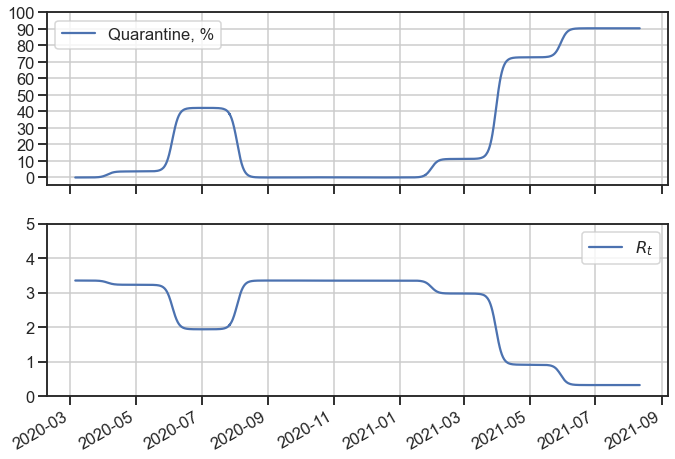

In [113]:
history_dates = df.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Quarantine, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

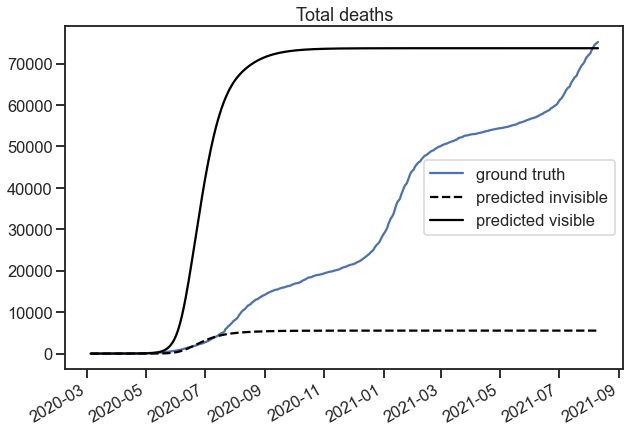

In [115]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['Deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
fig.autofmt_xdate()
plt.show()

In [116]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-06-01', end=last_day)[::20]
len(eval_dates)

35